In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [2]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)


print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))


Train data shape: (126000, 3072)
Train labels shape: (126000, 10)
Test data shape: (14000, 3072)
Test labels shape: (14000, 10)


In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# 注意：根据你的数据调整input_shape
model = build_resnet_model(input_shape=(32, 32, 3), num_classes=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
import numpy as np

# 假设 train_data_reshaped 和 train_labels 是你的完整训练数据和标签

# sample_size = 18000*7  # 选择一个适合你计算资源的样本大小
# indices = np.random.choice(range(len(train_data_reshaped)), sample_size, replace=False)

# train_data_sample = train_data_reshaped[indices]
# train_labels_sample = train_labels[indices]

# 然后使用这个更小的数据集进行训练
history = model.fit(train_data_reshaped, train_labels, validation_split=0.1, epochs=30, batch_size=64)


Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 973s 542ms/step - accuracy: 0.6001 - loss: 0.9626 - val_accuracy: 0.3937 - val_loss: 25.0357
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 939s 530ms/step - accuracy: 0.7939 - loss: 0.4479 - val_accuracy: 0.6663 - val_loss: 1.5783
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 932s 526ms/step - accuracy: 0.8376 - loss: 0.3362 - val_accuracy: 0.3106 - val_loss: 3.7475
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 937s 529ms/step - accuracy: 0.8858 - loss: 0.2698 - val_accuracy: 0.5459 - val_loss: 2.3878
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 934s 527ms/step - accuracy: 0.9117 - loss: 0.2253 - val_accuracy: 0.7323 - val_loss: 0.9790
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 937s 529ms/step - accuracy: 0.9236 - loss: 0.1931 - val_accuracy: 0.7677 - val_loss: 0.6030
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 936s 528ms/step - accuracy: 0.9385 - loss: 0.1541 - val_accuracy: 0.7534 - val_loss: 0.8141
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 936s 528ms/step - a

In [5]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/resNet0327-2.h5')  # HDF5文件
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/resNet0327-2.h5')

In [6]:
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


438/438 - 17s - 38ms/step - accuracy: 0.7944 - loss: 1.4088
测试集损失: 1.4087902307510376
测试集准确率: 0.7944285869598389


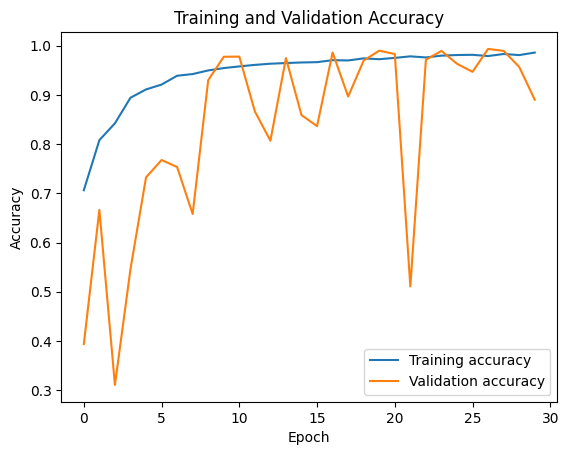

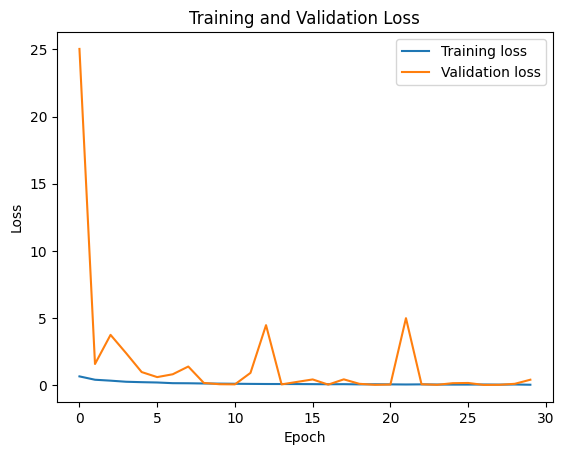

In [7]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 - 2s - 36ms/step - accuracy: 0.8120 - loss: 1.2649

Test accuracy: 0.8119999766349792
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       200
           5       0.39      1.00      0.56       200
           6       1.00      0.34      0.51       200
           7       1.00      1.00      1.00       200
           8       0.99      0.79      0.87       200
           9       0.82      0.99      0.90       200

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.78      2000
weighted avg       0.82      0.81      0.78      2000



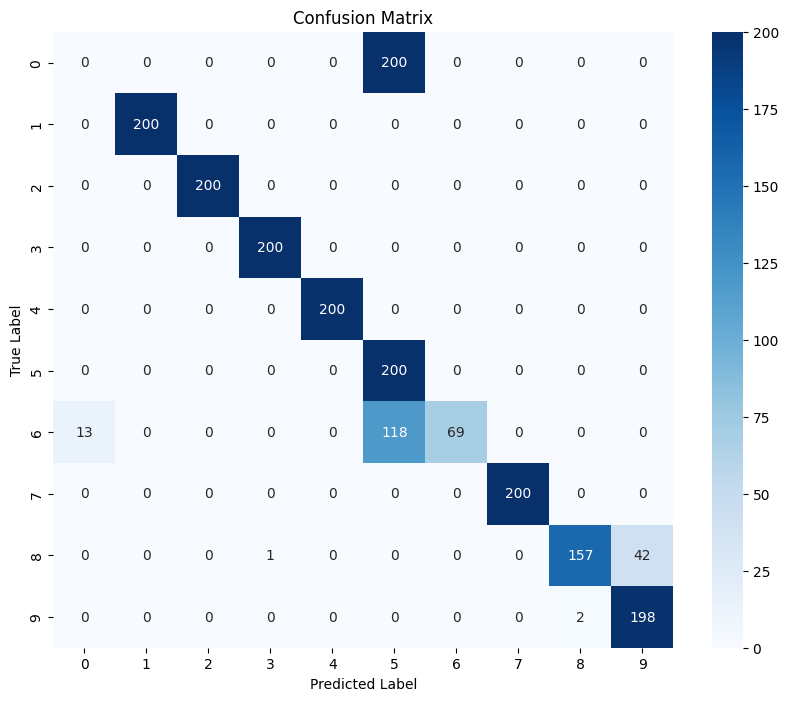

In [8]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
dBnumber = 20
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


63/63 - 2s - 37ms/step - accuracy: 0.7480 - loss: 1.4902

Test accuracy: 0.7480000257492065
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

           0       0.36      0.18      0.24       200
           1       1.00      0.98      0.99       200
           2       0.94      0.94      0.94       200
           3       0.93      0.89      0.91       200
           4       1.00      1.00      1.00       200
           5       0.46      1.00      0.63       200
           6       0.90      0.32      0.47       200
           7       1.00      0.99      0.99       200
           8       0.54      0.66      0.59       200
           9       0.62      0.54      0.58       200

    accuracy                           0.75      2000
   macro avg       0.78      0.75      0.73      2000
weighted avg       0.78      0.75      0.73      2000



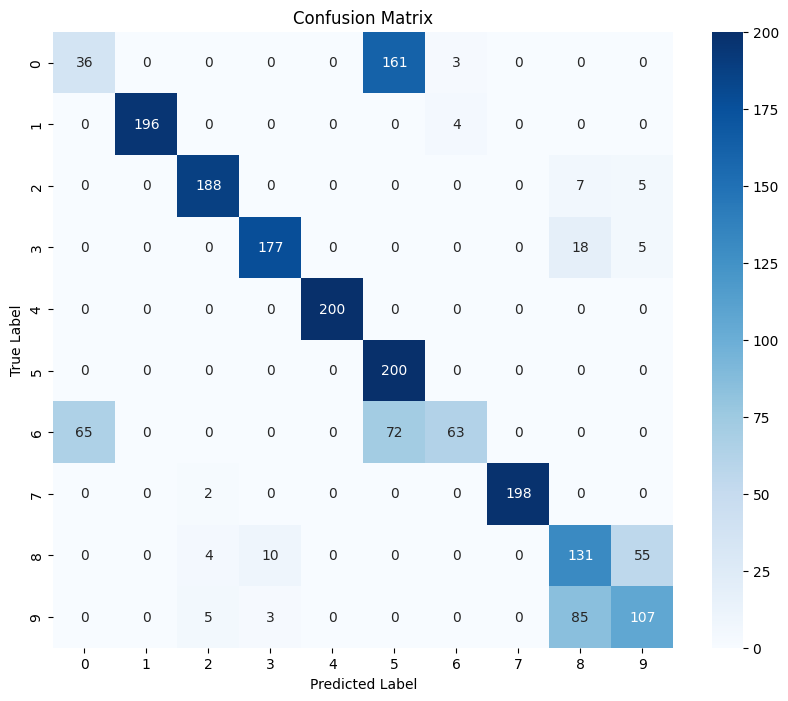

In [14]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_{dBnumber}.mat'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
dBnumber = 0
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


438/438 - 16s - 37ms/step - accuracy: 0.7944 - loss: 1.4088

Test accuracy: 0.7944285869598389
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step
              precision    recall  f1-score   support

           0       0.18      0.03      0.05      1400
           1       1.00      1.00      1.00      1400
           2       0.99      0.99      0.99      1400
           3       0.98      0.98      0.98      1400
           4       1.00      1.00      1.00      1400
           5       0.40      1.00      0.57      1400
           6       0.98      0.32      0.49      1400
           7       1.00      0.99      1.00      1400
           8       0.85      0.75      0.80      1400
           9       0.79      0.88      0.83      1400

    accuracy                           0.79     14000
   macro avg       0.82      0.79      0.77     14000
weighted avg       0.82      0.79      0.77     14000



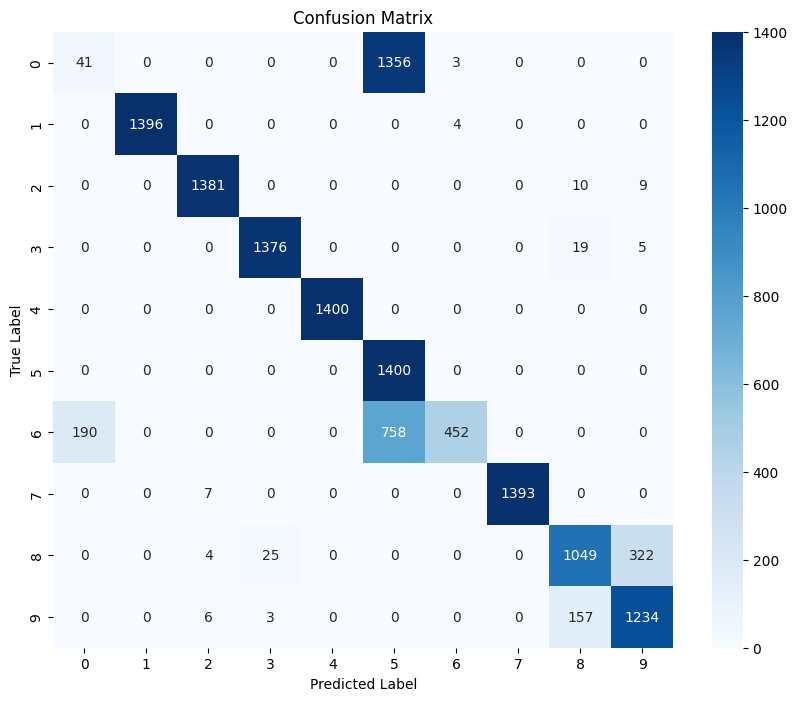

In [15]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def load_data_from_mat(path,dBnumber):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith(f'train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith(f'test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # print(test_data.shape, test_labels.shape)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
dBnumber = 0
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path,dBnumber)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
import matplotlib.pyplot as plt

# 获取历史数据
loaded_history = loaded_model.history
print(loaded_history)

AttributeError: 'History' object has no attribute 'History'

In [ ]:
# 绘制训练和验证损失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证准确率
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()